### 1．インポート

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import time
import datetime
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from urllib.request import urlopen
import optuna.integration.lightgbm as lgb_o
from scipy.special import comb

### 1.1　クラス

In [67]:
# 訓練データと出馬表データを加工する抽象クラス
class DataProcessor:
    def __init__(self):
        self.data = pd.DataFrame()
        # preprocessing後の変数
        self.data_p = pd.DataFrame()
        # horse_resultsをmergeした後の変数
        self.data_h = pd.DataFrame()
        # pedsをmergeした後の変数
        self.data_pe = pd.DataFrame()
        # カテゴリ変数化した後の変数
        self.data_c = pd.DataFrame()
        
    # 馬の過去成績データの追加
    def merge_horse_results(self, hr, n_samples_list=[5, 9, 'all']):
        self.data_h = self.data_p.copy()
        for n_samples in n_samples_list:
            self.data_h = hr.merge_all(self.data_h, n_samples=n_samples)
        self.data_h.drop(['開催'], axis=1, inplace=True)
            
    # 血統データ追加
    def merge_peds(self, peds):
        self.data_pe = self.data_h.merge(peds, left_on='horse_id', right_index=True, how='left')
        self.no_peds = self.data_pe[self.data_pe['peds_0'].isnull()]['horse_id'].unique()
        if len(self.no_peds):
            print('scrape peds at horse_id_list "no_peds"')
    
    # カテゴリ変数の処理
    def process_categorical(self, le_horse, le_jockey, results_m):
        df = self.data_pe.copy()
        
        # ラベルエンコーディング(horse_id, jockey_idを0始まりの整数に変換)
        # horse_id
        mask_horse = df['horse_id'].isin(le_horse.classes_)
        new_horse_id = df['horse_id'].mask(mask_horse).dropna().unique()
        le_horse.classes_ = np.concatenate([le_horse.classes_, new_horse_id])
        df['horse_id'] = le_horse.transform(df['horse_id'])
        
        # jockey_id
        mask_jockey = df['jockey_id'].isin(le_jockey.classes_)
        new_jockey_id = df['jockey_id'].mask(mask_jockey).dropna().unique()
        le_jockey.classes_ = np.concatenate([le_jockey.classes_, new_jockey_id])
        df['jockey_id'] = le_jockey.transform(df['jockey_id'])
        
        # horse_id, jockey_idをcategory型に変換
        df['horse_id'] = df['horse_id'].astype('category')
        df['jockey_id'] = df['jockey_id'].astype('category')
        
        # そのほかのカテゴリ変数をcategory型に変換してからダミー変数化
        weathers = results_m['weather'].unique()
        race_types = results_m['race_type'].unique()
        ground_states = results_m['ground_state'].unique()
        sexes = results_m['性'].unique()
        df['weather'] = pd.Categorical(df['weather'], weathers)
        df['race_type'] = pd.Categorical(df['race_type'], race_types)
        df['ground_state'] = pd.Categorical(df['ground_state'], ground_states)
        df['性'] = pd.Categorical(df['性'], sexes)
        
        df = pd.get_dummies(df, columns=['weather', 'race_type', 'ground_state', '性'])  
        self.data_c = df

# 予測に使う出馬表データを加工するクラス
class ShutubaTable(DataProcessor):
    def __init__(self, shutuba_tables):
        super(ShutubaTable, self).__init__()
        self.data = shutuba_tables
    
    @classmethod
    def scrape(cls, race_id_list, date):
        data = pd.DataFrame()
        for race_id in tqdm(race_id_list):
            url = f'https://race.netkeiba.com/race/shutuba.html?race_id={race_id}'
            df = pd.read_html(url)[0]
            df = df.T.reset_index(level=0, drop=True).T

            html = requests.get(url)
            html.encoding = 'EUC-JP'
            soup = BeautifulSoup(html.text, 'html.parser')

            # race_data
            texts = soup.find('div', attrs={'class': 'RaceData01'}).text
            texts = re.findall(r'\w+', texts)
            for text in texts:
                if 'm' in text:
                    df['course_len'] = [int(re.findall(r'\d+', text)[0])] * len(df)
                if text in ['曇', '晴', '雨', '小雨', '小雪', '雪']:
                    df['weather'] = [text] * len(df)
                if text in ['良', '稍重', '重']:
                    df['ground_state'] = [text] * len(df)
                if '不' in text:
                    df['ground_state'] = ['不良'] * len(df)
                if '芝' in text:
                    df['race_type'] = ['芝'] * len(df)
                if '障' in text:
                    df['race_type'] = ['障害'] * len(df)
                if 'ダ' in text:
                    df['race_type'] = ['ダート'] * len(df)
            df['date'] = [date] * len(df)

            # horse_id
            horse_id_list = []
            horse_td_list = soup.find_all('td', attrs={'class': 'HorseInfo'})
            for td in horse_td_list:
                horse_id = re.findall(r'\d+', td.find('a')['href'])[0]
                horse_id_list.append(horse_id)
            df['horse_id'] = horse_id_list

            # jockey_id
            jockey_id_list = []
            jockey_td_list = soup.find_all('td', attrs={'class': 'Jockey'})
            for td in jockey_td_list:
                jockey_id = re.findall(r'\d+', td.find('a')['href'])[0]
                jockey_id_list.append(jockey_id)
            df['jockey_id'] = jockey_id_list

            df.index = [race_id] * len(df)
            data = data.append(df)
            time.sleep(1)
        
        return cls(data)
    
    # 前処理
    def preprocessing(self):
        df = self.data.copy()
        
        # 性齢を性と年齢に分ける
        df['性'] = df['性齢'].map(lambda x: str(x)[0])
        df['年齢'] = df['性齢'].map(lambda x: str(x)[1:]).astype(int)

        # 馬体重を体重と体重変化に分ける
        df = df[df['馬体重(増減)'] != '--']
        df['体重'] = df['馬体重(増減)'].str.split('(', expand=True)[0].astype(int)
        df['体重変化'] = df['馬体重(増減)'].str.split('(', expand=True)[1].str[:-1].astype(int)
        
        # 日付をdatetime型に変更
        df['date'] = pd.to_datetime(df['date'])

        # データをint, floatに変換
        df['枠'] = df['枠'].astype(int)
        df['馬番'] = df['馬番'].astype(int)
        df['斤量'] = df['斤量'].astype(int)

    
        # 必要な列だけにする
        df = df[['枠', '馬番', '斤量', 'course_len', 'weather', 'race_type', 'ground_state', 'date', 'horse_id', 'jockey_id', '性', '年齢', '体重', '体重変化']]
        df['開催'] = df.index.map(lambda x:str(x)[4:6])

        self.data_p = df.rename(columns={'枠': '枠番'})

# 訓練に使う過去レースデータを加工するクラス
class Results(DataProcessor):
    def __init__(self, results):
        super(Results, self).__init__()
        self.data = results
    
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.read_pickle(path_list[0])
        for path in path_list[1:]:
            df = update_data(df, pd.read_pickle(path))
        return cls(df)
    
    @staticmethod
    def scrape(race_id_list):
        # race_idをkeyにしてDataFrame型を格納
        race_results = {}
        for race_id in tqdm(race_id_list):
            time.sleep(1)
            try:
                url = f'https://db.netkeiba.com/race/{race_id}'
                # メインとなるテーブルデータを取得
                df = pd.read_html(url)[0]

                html = requests.get(url)
                html.encoding = 'EUC-JP'
                soup = BeautifulSoup(html.text, 'html.parser')

                # 天候、レースの種類、コースの長さ、馬場の状態、日付をスクレイピング
                texts = (
                    soup.find('div', attrs={'class': 'data_intro'}).find_all('p')[0].text
                    + soup.find('div', attrs={'class': 'data_intro'}).find_all('p')[1].text
                )
                info = re.findall(r'\w+', texts)
                for text in info:
                    if text in ['芝', 'ダート']:
                        df['race_type'] = [text] * len(df)
                    if '障' in text:
                        df['race_type'] = ['障害'] * len(df)
                    if 'm' in text:
                        df['course_len'] = [int(re.findall(r'\d+', text)[0])] * len(df)
                    if text in ['良', '稍重', '重', '不良']:
                        df['ground_state'] = [text] * len(df)
                    if text in ['曇', '晴', '雨', '小雨', '小雪', '雪']:
                        df['weather'] = [text] * len(df)
                    if '年' in text:
                        df['date'] = [text] * len(df)

                # 馬ID、騎手IDをスクレイピング
                horse_id_list = []
                horse_a_list = soup.find('table', attrs={'summary': 'レース結果'}).find_all('a', attrs={'href': re.compile('^/horse')})
                for a in horse_a_list:
                    horse_id = re.findall(r'\d+', a['href'])
                    horse_id_list.append(horse_id[0])
                jockey_id_list = []
                jockey_a_list = soup.find("table", attrs={'summary': 'レース結果'}).find_all('a', attrs={'href': re.compile('^/jockey')})
                for a in jockey_a_list:
                    jockey_id = re.findall(r'\d+', a['href'])
                    jockey_id_list.append(jockey_id[0])
                df['horse_id'] = horse_id_list
                df['jockey_id'] = jockey_id_list

                #インデックスをrace_idにする
                df.index = [race_id] * len(df)

                race_results[race_id] = df
            # 存在しないrace_idを飛ばす
            except IndexError:
                continue
            # wifiの接続が切れた時などでも途中までのデータを返せるようにする
            except Exception as e:
                print(e)
                break
            # Jupyterで停止ボタンを押した時の対処
            except:
                break

        # pd.DataFrame型にして一つのデータにまとめる
        race_results_df = pd.concat([race_results[key] for key in race_results])

        return race_results_df
    
    # 前処理
    def preprocessing(self):
        df = self.data.copy()

        # 着順に数字以外の文字列が含まれているものを取り除く
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
        df['着順'] = df['着順'].astype(int)
        df['rank'] = df['着順'].map(lambda x: 1 if x < 4 else 0)

        # 性齢を性と年齢に分ける
        df['性'] = df['性齢'].map(lambda x: str(x)[0])
        df['年齢'] = df['性齢'].map(lambda x: str(x)[1:]).astype(int)

        # 馬体重を体重と体重変化に分ける
        df['体重'] = df['馬体重'].str.split('(', expand=True)[0].astype(int)
        df['体重変化'] = df['馬体重'].str.split('(', expand=True)[1].str[:-1].astype(int)

        # データをint, floatに変換
        df['単勝'] = df['単勝'].astype(float)
        df['course_len'] = df['course_len'].astype(float) // 100

        # 不要な列を削除
        df.drop(['タイム', '着差', '調教師', '性齢', '馬体重', '馬名', '騎手', '人気', '着順'], axis=1, inplace=True)

        df['date'] = pd.to_datetime(df['date'], format='%Y年%m月%d日')
        
        # 開催場所
        df['開催'] = df.index.map(lambda x: str(x)[4:6])

        self.data_p = df
    
    # カテゴリ変数の処理
    def process_categorical(self):
        self.le_horse = LabelEncoder().fit(self.data_pe['horse_id'])
        self.le_jockey = LabelEncoder().fit(self.data_pe['jockey_id'])        
        super().process_categorical(self.le_horse, self.le_jockey, self.data_pe)

# 馬の過去成績データを処理するクラス
class HorseResults:
    def __init__(self, horse_results):
        self.horse_results = horse_results[['日付', '着順', '賞金', '着差', '通過', '開催', '距離']]
        self.preprocessing()
    
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.read_pickle(path_list[0])
        for path in path_list[1:]:
            df = update_data(df, pd.read_pickle(path))
        return cls(df)
    
    @staticmethod
    def scrape(horse_id_list):
        # horse_idをkeyにしてDataFrame型を格納
        horse_results = {}
        for horse_id in tqdm(horse_id_list):
            try:
                time.sleep(1)
                url = f'https://db.netkeiba.com/horse/{horse_id}'
                # メインとなるテーブルデータを取得
                df = pd.read_html(url)[3]
                # 受賞歴がある馬の場合、4番目に受賞歴テーブルが来るため、5番目のデータを取得する
                if df.columns[0] == '受賞歴':
                    df = pd.read_html(url)[4]
                horse_results[horse_id] = df
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break
        
        # pd.DataFrame型にして一つのデータにまとめる
        horse_results_df = pd.concat([horse_results[key] for key in horse_results])
        
        return horse_results_df
        
    def preprocessing(self):
        df = self.horse_results.copy()
        
        # 着順に数字以外の文字列が含まれているものを取り除く
        df['着順'] = pd.to_numeric(df['着順'], errors='coerce')
        df.dropna(subset=['着順'], inplace=True)
        df['着順'] = df['着順'].astype(int)
        
        df['date'] = pd.to_datetime(df['日付'])
        df.drop(['日付'], axis=1, inplace=True)
        
        # 賞金の欠損値を0で埋める
        df['賞金'].fillna(0, inplace=True)
        
        # 1着の着差を0にする
        df['着差'] = df['着差'].map(lambda x: 0 if x < 0 else x)
                                            
        # レース展開データ
        def corner(x, n):
            if type(x) != str:
                return x
            # n=1: 最初のコーナー位置、n=4: 最終コーナー位置
            if n == 1:
                return int(re.findall(r'\d+', x)[0])
            if n == 4:
                return int(re.findall(r'\d+', x)[-1])
                                            
        df['first_corner'] = df['通過'].map(lambda x: corner(x, 1))
        df['final_corner'] = df['通過'].map(lambda x: corner(x, 4))
        
        df['final_to_rank'] = df['final_corner'] - df['着順']
        df['first_to_rank'] = df['first_corner'] - df['着順']
        df['first_to_final'] = df['first_corner'] - df['final_corner']
        
        # 開催場所
        df['開催'] = df['開催'].str.extract(r'(\D+)')[0].map(place_dict).fillna('11')
        # race_type
        df['race_type'] = df['距離'].str.extract(r'(\D+)')[0].map(race_type_dict)
        # 距離
        df['course_len'] = df['距離'].str.extract(r'(\d+)').astype(int) // 100
        df.drop(['距離'], axis=1, inplace=True)
        
        # インデックス名を与える
        df.index.name = 'horse_id'
        
        self.horse_results = df
        self.target_list = ['着順', '賞金', '着差', 'first_corner', 'final_corner', 'final_to_rank', 'first_to_rank', 'first_to_final']
    
    def average(self, horse_id_list, date, n_samples='all'):
        target_df = self.horse_results.query('index in @horse_id_list')
        
        # 過去何走分取り出すか指定
        if n_samples == 'all':
            filtered_df = target_df[target_df['date'] < date]
        elif n_samples > 0:
            filtered_df = target_df[target_df['date'] < date].sort_values('date', ascending=False).groupby(level=0).head(n_samples)
        else:
            raise Exception('n_samples must be integer')
        
        self.average_dict = {}
        self.average_dict['non_category'] = filtered_df.groupby(level=0)[self.target_list].mean().add_suffix(f'_{n_samples}R')
        for column in ['course_len', 'race_type', '開催']:
            self.average_dict[column] = filtered_df.groupby(['horse_id', column])[self.target_list].mean().add_suffix(f'_{column}_{n_samples}R')
    
    def merge(self, results, date, n_samples='all'):
        df = results[results['date'] == date]
        horse_id_list = df['horse_id']
        self.average(horse_id_list, date, n_samples)
        merged_df = df.merge(self.average_dict['non_category'], left_on='horse_id', right_index=True, how='left')
        for column in ['course_len', 'race_type', '開催']:
            merged_df = merged_df.merge(self.average_dict[column], left_on=['horse_id', column], right_index=True, how='left')
        return merged_df
    
    def merge_all(self, results, n_samples='all'):
        date_list = results['date'].unique()
        merged_df = pd.concat([self.merge(results, date, n_samples) for date in date_list])
        return merged_df

# 血統データを処理するクラス
class Peds:
    def __init__(self, peds):
        self.peds = peds
        # LabelEncodingしてcategory型にした変数
        self.peds_e = pd.DataFrame()
    
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.read_pickle(path_list[0])
        for path in path_list[1:]:
            df = update_data(df, pd.read_pickle(path))
        return cls(df)
    
    @staticmethod
    def scrape(horse_id_list):
        # 血統データを取り出す
        peds_dict = {}
        for horse_id in tqdm(horse_id_list):
            try:
                url = f'https://db.netkeiba.com/horse/ped/{horse_id}'
                df = pd.read_html(url)[0]

                # 重複を削除して1列のSeries型データに治す
                generations = {}
                for i in reversed(range(5)):
                    generations[i] = df[i]
                    df.drop([i], axis=1, inplace=True)
                    df = df.drop_duplicates()

                ped = pd.concat([generations[i] for i in range(5)]).rename(horse_id)
                peds_dict[horse_id] = ped.reset_index(drop=True)
                time.sleep(1)
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break
        
        # 列名をpeds_0, ..., peds_61にする
        peds_df = pd.concat([peds_dict[key] for key in peds_dict], axis=1).T.add_prefix('peds_')
        
        return peds_df
    
    def encode(self):
        df = self.peds.copy()
        for column in df.columns:
            df[column] = LabelEncoder().fit_transform(df[column].fillna('Na'))
        self.peds_e = df.astype('category')

# 払い戻しデータを加工するクラス
class Return:
    def __init__(self, return_tables):
        self.return_tables = return_tables
    
    @classmethod
    def read_pickle(cls, path_list):
        df = pd.read_pickle(path_list[0])
        for path in path_list[1:]:
            df = update_data(df, pd.read_pickle(path))
        return cls(df)
    
    @staticmethod
    def scrape(race_id_list):
        return_tables = {}
        for race_id in tqdm(race_id_list):
            try:
                url = f'https://db.netkeiba.com/race/{race_id}'

                # 複勝やワイドなどが区切られてしまうため、改行コードを文字列に変換して後でsplitする
                f = urlopen(url)
                html = f.read()
                html = html.replace(b'<br />', b'br')            
                dfs = pd.read_html(html)

                # dfsの2番目に単勝～馬連、3番目にワイド～3連単がある
                df = pd.concat([dfs[1], dfs[2]])
                
                df.index = [race_id] * len(df)
                return_tables[race_id] = df
                time.sleep(1)
            except IndexError:
                continue
            except Exception as e:
                print(e)
                break
            except:
                break
        
        # pd.DataFrame型にして一つのデータにまとめる
        return_tables_df = pd.concat([return_tables[key] for key in return_tables])
        
        return return_tables_df
    
    @property
    def fukusho(self):
        # 複勝の勝ち馬と払い戻しのデータを取り出す
        fukusho = self.return_tables[self.return_tables[0] == '複勝'][[1, 2]]
        
        # 勝ち馬
        wins = fukusho[1].str.split('br', expand=True)[[0, 1, 2]]
        wins.columns = ['win_0', 'win_1', 'win_2']
        
        # 払い戻し
        returns = fukusho[2].str.split('br', expand=True)[[0, 1, 2]]
        returns.columns = ['return_0', 'return_1', 'return_2']
        
        df = pd.concat([wins, returns], axis=1)
        
        # int型に変換できないデータがあるので処理
        for column in df.columns:
            df[column] = df[column].str.replace(',', '')
            
        df = df.fillna(0).astype(int)
        
        return df
    
    @property
    def tansho(self):
        tansho = self.return_tables[self.return_tables[0] == '単勝'][[1, 2]]
        tansho.columns = ['win', 'return']
        
        for column in tansho.columns:
            tansho[column] = pd.to_numeric(tansho[column], errors='coerce')
            
        return tansho
    
    @property
    def umaren(self):
        umaren = self.return_tables[self.return_tables[0] == '馬連'][[1, 2]]
        wins = umaren[1].str.split('-', expand=True)[[0, 1]].add_prefix('win_')
        return_ = umaren[2].rename('return')
        df = pd.concat([wins, return_], axis=1)      
        df = df.apply(lambda x: pd.to_numeric(x, errors='coerce'))
        
        return df

# 予測モデルを評価するクラス
class ModelEvaluator:
    def __init__(self, model, return_tables_path, std=True):
        self.model = model
        self.rt = Return.read_pickle([return_tables_path])
        self.fukusho = self.rt.fukusho
        self.tansho = self.rt.tansho
        self.umaren = self.rt.umaren
        self.std = std
        
    def predict_proba(self, x):
        # 1（3着以内）になる確率を予測
        proba = pd.Series(self.model.predict_proba(x.drop(['単勝'], axis=1))[:, 1], index=x.index)
        if self.std:
            # 標準化：レース内で相対評価する
            standard_scaler = lambda x: (x - x.mean()) / x.std()
            proba = proba.groupby(level=0).transform(standard_scaler)
            # MinMaxスケーリング：データを0から1にする
            proba = (proba - proba.min()) / (proba.max() - proba.min())
        return proba
    
    def predict(self, x, threshold=0.5):
        # thresholdの値によってpredict_probaで出した値を0か1に決定する
        y_pred = self.predict_proba(x)
        return [0 if p < threshold else 1 for p in y_pred]
    
    def score(self, y_true, x):
        # スコアを表示
        return roc_auc_score(y_true, self.predict_proba(x))
    
    def feature_importance(self, x, n_display=20):
        # 変数の重要度を出力
        importances = pd.DataFrame(
            {"features": x.columns, "importance": self.model.feature_importances_}
        )
        return importances.sort_values('importance', ascending=False)[:n_display]
    
    def pred_table(self, x, threshold=0.5, bet_only=True):
        # 予測したレースIDと馬番を出力する
        pred_table = x.copy()[['馬番', '単勝']]
        pred_table['pred'] = self.predict(x, threshold)
        
        if bet_only:
            return pred_table[pred_table['pred'] == 1][['馬番', '単勝']]
        
        return pred_table
    
    def fukusho_return(self, x, threshold=0.5):
        # 複勝の払い戻しを表示
        pred_table = self.pred_table(x, threshold)
        n_bets = len(pred_table)
        money = -100 * n_bets
        df = self.fukusho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        for i in range(3):
            money += df[df[f'win_{i}'] == df['馬番']][f'return_{i}'].sum()
        return_rate = (n_bets * 100 + money) / (n_bets * 100)
        return n_bets, return_rate
    
    def tansho_return(self, x, threshold=0.5):
        # 単勝の払い戻しを表示
        pred_table = self.pred_table(x, threshold)
        n_bets = len(pred_table)
        n_races = pred_table.index.nunique()
        
        money = -100 * n_bets
        df = self.tansho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        
        std = ((df['win'] == df['馬番']) * df['return']).groupby(level=0).sum().std() * np.sqrt(n_races) / (100 * n_bets)
        
        n_hits = len(df[df['win'] == df['馬番']])
        money += df[df['win'] == df['馬番']]['return'].sum()
        return_rate = (n_bets * 100 + money) / (n_bets * 100)
        return n_bets, return_rate, n_hits, std
    
    def tansho_return_proper(self, x, threshold=0.5):
        # モデルによって「賭ける」と判断された馬たち
        pred_table = self.pred_table(x, threshold)
        n_bets = len(pred_table)
        n_races = pred_table.index.nunique()
        
        # 払い戻し表にpred_tableをマージ
        df = self.tansho.copy()
        df = df.merge(pred_table, left_index=True, right_index=True, how='right')
        
        bet_money = (1 / pred_table['単勝']).sum()
        
        std = ((df['win'] == df['馬番']).astype(int)).groupby(level=0).sum().std() * np.sqrt(n_races) / bet_money
        
        # 単勝適正回収値を計算
        n_hits = len(df.query('win == 馬番'))
        return_rate = n_hits / bet_money
        
        return n_bets, return_rate, n_hits, std
    
    def umaren_return(self, x, threshold=0.5):
        pred_table = self.pred_table(x, threshold)
        hit = {}
        n_bets = 0
        for race_id, preds in pred_table.groupby(level=0):
            n_bets += comb(len(preds, 2))
            hit[race_id] = set(self.umaren.loc[race_id][['win_0', 'win_1']]).issubset(set(preds))
        return_rate = self.umaren.index.map(hit).values * self.umaren['return'].sum() / (n_bets * 100)
        return n_bets, return_rate

### 1.2　その他の定義

### 2．前処理

In [49]:
# 時系列に沿って訓練データとテストデータに分ける関数
def split_data(df, test_size=0.3):
    sorted_id_list = df.sort_values('date').index.unique()   
    train_id_list = sorted_id_list[:round(len(sorted_id_list) * (1 - test_size))]
    test_id_list = sorted_id_list[round(len(sorted_id_list) * (1 - test_size)):]
    train = df.loc[train_id_list]#.drop(['date'], axis=1)
    test = df.loc[test_id_list]#.drop(['date'], axis=1)
    return train, test

# 回収率を計算する関数
def gain(return_func, x, n_samples=100, min_threshold=0.5):
    gain = {}
    for i in tqdm(range(n_samples)):
        threshold = (i / n_samples) + (min_threshold * (1 - (i / n_samples)))
        n_bets, return_rate, n_hits, std = return_func(x, threshold)
        if n_bets > 2:
            gain[n_bets] = {'return_rate': return_rate, 'n_hits': n_hits, 'std': std}
    return pd.DataFrame(gain).T

# 重複のないデータを作成する関数
def update_data(old, new):
    filtered_old = old[~old.index.isin(new.index)]
    return pd.concat([filtered_old, new])

place_dict = {
    '札幌': '01', '函館': '02', '福島': '03', '新潟': '04', '東京': '05',
    '中山': '06', '中京': '07', '京都': '08', '阪神': '09', '小倉': '10'
}

race_type_dict = {
    '芝': '芝', 'ダ': 'ダート', '障': '障害'
}

In [4]:
r = Results.read_pickle(['results.pickle'])

# 前処理
r.preprocessing()

# 馬の過去成績データの追加
hr = HorseResults.read_pickle(['horse_results.pickle'])
r.merge_horse_results(hr)

# 5世代分の血統データの追加
p = Peds.read_pickle(['peds.pickle'])
p.encode()
r.merge_peds(p.peds_e)

# カテゴリ変数の処理
r.process_categorical()

In [ ]:
r.data_h

### 3．予測

In [16]:
# 時系列に沿って訓練データとテストデータに分ける
train, test = split_data(r.data_c)
X_train = train.drop(['rank', 'date', '単勝'], axis=1)
y_train = train['rank']
X_test = test.drop(['rank', 'date'], axis=1)
y_test = test['rank']

In [ ]:
params = {
    'num_leaves': 4,
    'n_estimators': 80,
    'class_weight': 'balanced',
    'random_state': 100
}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values)

In [ ]:
me = ModelEvaluator(lgb_clf, 'return_tables.pickle')

In [ ]:
# gain_baseline = gain(me.tansho_return, X_test)
# gain_baseline.to_pickle('gain_baseline.pickle')

In [ ]:
gain_baseline = pd.read_pickle('gain_baseline.pickle')

#### 4．単勝適性回収値
常に払戻額が一定になるように単勝で賭けた場合の回収率<br>
払戻額が常に1万円になるように賭けてみる

賭けた金額<br>
x円賭けるとすると<br>
$$
各馬番の単勝オッズ \times \frac{x}{100} = 10000 \\
\therefore \quad x = \frac{100 \times 10000}{各馬番の単勝オッズ}
$$

回収率 = 払戻額 / 賭けた金額

In [ ]:
# gain_proper = gain(me.tansho_return_proper, X_test)
# gain_proper.to_pickle('gain_proper.pickle')

In [ ]:
gain_proper = pd.read_pickle('gain_proper.pickle')

In [ ]:
plt.figure(figsize=(10, 8))
gain_baseline.rename('baseline').plot(legend=True)
gain_proper.rename('proper').plot(legend=True)
plt.grid()

### 5．Optuna

In [8]:
# 訓練データ、検証データ、テストデータに分ける
train, test = split_data(r.data_c)
train, valid = split_data(train)

In [9]:
# 説明変数と目的変数に分ける
X_train = train.drop(['rank', 'date'], axis=1)
y_train = train['rank']
X_valid = valid.drop(['rank', 'date'], axis=1)
y_valid = valid['rank']
X_test = test.drop(['rank', 'date'], axis=1)
y_test = test['rank']

In [10]:
# データセットの作成
lgb_train = lgb_o.Dataset(X_train.values, y_train.values)
lgb_valid = lgb_o.Dataset(X_valid.values, y_valid.values)

# チューニング実行
params = {
    'objective': 'binary',
    'random_state': 100
}

lgb_clf_o = lgb_o.train(params, lgb_train, valid_sets=(lgb_train, lgb_valid), verbose_eval=100, early_stopping_rounds=10)

[I 2022-03-26 14:19:05,321] A new study created in memory with name: no-name-62093303-7f95-48de-b339-ebc76b1b2d5e
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.410068:  14%|#4        | 1/7 [00:05<00:32,  5.34s/it]

Early stopping, best iteration is:
[40]	valid_0's binary_logloss: 0.38361	valid_1's binary_logloss: 0.410068
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.410068:  29%|##8       | 2/7 [00:10<00:26,  5.38s/it]

Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.378171	valid_1's binary_logloss: 0.41167
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.410068:  43%|####2     | 3/7 [00:16<00:21,  5.47s/it]

Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.387415	valid_1's binary_logloss: 0.410489
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.410068:  57%|#####7    | 4/7 [00:21<00:16,  5.41s/it]

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.383573	valid_1's binary_logloss: 0.410271
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.410068:  71%|#######1  | 5/7 [00:27<00:11,  5.63s/it]

Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.386313	valid_1's binary_logloss: 0.410847
Training until validation scores don't improve for 10 rounds


feature_fraction, val_score: 0.410068:  86%|########5 | 6/7 [00:33<00:05,  5.64s/it]

Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.376871	valid_1's binary_logloss: 0.411319
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.410068:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.379325	valid_1's binary_logloss: 0.411075
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.408526:   5%|5         | 1/20 [00:04<01:18,  4.11s/it]

Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.40478	valid_1's binary_logloss: 0.408526
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.408526:  10%|#         | 2/20 [00:09<01:21,  4.55s/it]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.380665	valid_1's binary_logloss: 0.410764
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.408526:  15%|#5        | 3/20 [00:20<01:50,  6.50s/it]

Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.291544	valid_1's binary_logloss: 0.418421
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.408526:  20%|##        | 4/20 [00:32<02:07,  7.97s/it]

Early stopping, best iteration is:
[23]	valid_0's binary_logloss: 0.307383	valid_1's binary_logloss: 0.418738
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.408526:  25%|##5       | 5/20 [00:37<01:47,  7.18s/it]

Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.389325	valid_1's binary_logloss: 0.409524
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.408526:  30%|###       | 6/20 [00:47<01:53,  8.12s/it]

Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.299827	valid_1's binary_logloss: 0.416231
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.408526:  35%|###5      | 7/20 [00:53<01:37,  7.51s/it]

Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.36616	valid_1's binary_logloss: 0.41131
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.408526:  40%|####      | 8/20 [01:03<01:37,  8.09s/it]

Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.314664	valid_1's binary_logloss: 0.416752
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.408526:  45%|####5     | 9/20 [01:07<01:15,  6.88s/it]

Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.40478	valid_1's binary_logloss: 0.408526
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.408526:  50%|#####     | 10/20 [01:12<01:04,  6.44s/it]

Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.381279	valid_1's binary_logloss: 0.41073
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.408526:  55%|#####5    | 11/20 [01:19<00:59,  6.59s/it]

Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.349127	valid_1's binary_logloss: 0.413784
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.408526:  60%|######    | 12/20 [01:26<00:52,  6.54s/it]

Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.353145	valid_1's binary_logloss: 0.41322
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.408526:  65%|######5   | 13/20 [01:32<00:46,  6.59s/it]

Early stopping, best iteration is:
[29]	valid_0's binary_logloss: 0.360262	valid_1's binary_logloss: 0.413028
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.410563	valid_1's binary_logloss: 0.409116


num_leaves, val_score: 0.408526:  70%|#######   | 14/20 [01:36<00:34,  5.76s/it]

Early stopping, best iteration is:
[155]	valid_0's binary_logloss: 0.409453	valid_1's binary_logloss: 0.408792
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.408526:  75%|#######5  | 15/20 [01:45<00:33,  6.66s/it]

Early stopping, best iteration is:
[30]	valid_0's binary_logloss: 0.327828	valid_1's binary_logloss: 0.415382
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.408526:  80%|########  | 16/20 [01:51<00:26,  6.53s/it]

Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.358109	valid_1's binary_logloss: 0.411861
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.408526:  85%|########5 | 17/20 [01:55<00:17,  5.83s/it]

[100]	valid_0's binary_logloss: 0.406246	valid_1's binary_logloss: 0.408622
Early stopping, best iteration is:
[95]	valid_0's binary_logloss: 0.406528	valid_1's binary_logloss: 0.408564
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.408526:  90%|######### | 18/20 [02:04<00:13,  6.66s/it]

Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.322197	valid_1's binary_logloss: 0.414312
Training until validation scores don't improve for 10 rounds


num_leaves, val_score: 0.408526:  95%|#########5| 19/20 [02:10<00:06,  6.50s/it]

Early stopping, best iteration is:
[39]	valid_0's binary_logloss: 0.359467	valid_1's binary_logloss: 0.41232
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.408526:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[28]	valid_0's binary_logloss: 0.339185	valid_1's binary_logloss: 0.414443
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.408526:  10%|#         | 1/10 [00:03<00:32,  3.60s/it]

Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.404825	valid_1's binary_logloss: 0.409055
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.408526:  20%|##        | 2/10 [00:07<00:28,  3.62s/it]

Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.405613	valid_1's binary_logloss: 0.409388
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.408526:  30%|###       | 3/10 [00:11<00:27,  3.94s/it]

Early stopping, best iteration is:
[75]	valid_0's binary_logloss: 0.401361	valid_1's binary_logloss: 0.408541
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.408526:  40%|####      | 4/10 [00:15<00:23,  3.94s/it]

Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.404407	valid_1's binary_logloss: 0.409251
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.408526:  50%|#####     | 5/10 [00:19<00:18,  3.77s/it]

Early stopping, best iteration is:
[43]	valid_0's binary_logloss: 0.406667	valid_1's binary_logloss: 0.408759
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.408526:  60%|######    | 6/10 [00:23<00:15,  3.78s/it]

Early stopping, best iteration is:
[53]	valid_0's binary_logloss: 0.404926	valid_1's binary_logloss: 0.40911
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.408526:  70%|#######   | 7/10 [00:26<00:11,  3.73s/it]

Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.405309	valid_1's binary_logloss: 0.408708
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.408203:  80%|########  | 8/10 [00:31<00:08,  4.01s/it]

Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.403111	valid_1's binary_logloss: 0.408203
Training until validation scores don't improve for 10 rounds


bagging, val_score: 0.408203:  90%|######### | 9/10 [00:35<00:03,  3.99s/it]

Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.404227	valid_1's binary_logloss: 0.408604
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.408203:   0%|          | 0/6 [00:00<?, ?it/s]

Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.405151	valid_1's binary_logloss: 0.409187
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.408203:  17%|#6        | 1/6 [00:04<00:20,  4.14s/it]

Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.403478	valid_1's binary_logloss: 0.40848
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.408203:  33%|###3      | 2/6 [00:08<00:17,  4.27s/it]

Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.401784	valid_1's binary_logloss: 0.408561
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.408203:  50%|#####     | 3/6 [00:12<00:12,  4.19s/it]

Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.405415	valid_1's binary_logloss: 0.408611
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.408203:  67%|######6   | 4/6 [00:17<00:08,  4.26s/it]

Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.402312	valid_1's binary_logloss: 0.408466
Training until validation scores don't improve for 10 rounds


feature_fraction_stage2, val_score: 0.408203:  83%|########3 | 5/6 [00:21<00:04,  4.26s/it]

Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.403156	valid_1's binary_logloss: 0.408317
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.408203:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.404636	valid_1's binary_logloss: 0.409012
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.408203:   5%|5         | 1/20 [00:04<01:20,  4.26s/it]

Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.402642	valid_1's binary_logloss: 0.4083
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.408203:  10%|#         | 2/20 [00:08<01:17,  4.30s/it]

Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.403112	valid_1's binary_logloss: 0.408203
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.408203:  15%|#5        | 3/20 [00:13<01:13,  4.34s/it]

Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.402383	valid_1's binary_logloss: 0.408476
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.408199:  20%|##        | 4/20 [00:17<01:08,  4.29s/it]

Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.403111	valid_1's binary_logloss: 0.408199
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.408199:  25%|##5       | 5/20 [00:21<01:03,  4.23s/it]

Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.403111	valid_1's binary_logloss: 0.408203
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.408199:  30%|###       | 6/20 [00:25<00:59,  4.25s/it]

Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.403378	valid_1's binary_logloss: 0.408337
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.408199:  35%|###5      | 7/20 [00:30<00:57,  4.45s/it]

Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.40183	valid_1's binary_logloss: 0.408571
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.408199:  40%|####      | 8/20 [00:34<00:51,  4.30s/it]

Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.403111	valid_1's binary_logloss: 0.408199
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.408199:  45%|####5     | 9/20 [00:38<00:46,  4.27s/it]

Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.403111	valid_1's binary_logloss: 0.408199
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.408199:  50%|#####     | 10/20 [00:42<00:42,  4.25s/it]

Early stopping, best iteration is:
[60]	valid_0's binary_logloss: 0.403779	valid_1's binary_logloss: 0.408362
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.408199:  55%|#####5    | 11/20 [00:47<00:39,  4.34s/it]

Early stopping, best iteration is:
[57]	valid_0's binary_logloss: 0.404843	valid_1's binary_logloss: 0.408378
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.408199:  60%|######    | 12/20 [00:51<00:34,  4.26s/it]

Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.403112	valid_1's binary_logloss: 0.408203
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.408199:  65%|######5   | 13/20 [00:55<00:29,  4.26s/it]

Early stopping, best iteration is:
[63]	valid_0's binary_logloss: 0.403111	valid_1's binary_logloss: 0.408203
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.408197:  70%|#######   | 14/20 [01:00<00:25,  4.25s/it]

Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.405086	valid_1's binary_logloss: 0.408197
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.408190:  75%|#######5  | 15/20 [01:04<00:22,  4.43s/it]

Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.404263	valid_1's binary_logloss: 0.40819
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.408190:  80%|########  | 16/20 [01:10<00:18,  4.68s/it]

Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.40436	valid_1's binary_logloss: 0.408466
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.408141:  85%|########5 | 17/20 [01:14<00:13,  4.58s/it]

Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.404726	valid_1's binary_logloss: 0.408141
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.408141:  90%|######### | 18/20 [01:18<00:09,  4.51s/it]

Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.404875	valid_1's binary_logloss: 0.408679
Training until validation scores don't improve for 10 rounds


regularization_factors, val_score: 0.408141:  95%|#########5| 19/20 [01:22<00:04,  4.39s/it]

Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.40495	valid_1's binary_logloss: 0.408524
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.408141:   0%|          | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.405497	valid_1's binary_logloss: 0.408223
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.408080:  20%|##        | 1/5 [00:04<00:17,  4.31s/it]

Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.405186	valid_1's binary_logloss: 0.40808
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.408080:  40%|####      | 2/5 [00:08<00:13,  4.41s/it]

Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.403869	valid_1's binary_logloss: 0.408642
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.408080:  60%|######    | 3/5 [00:13<00:08,  4.44s/it]

Early stopping, best iteration is:
[61]	valid_0's binary_logloss: 0.404726	valid_1's binary_logloss: 0.408141
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.408019:  80%|########  | 4/5 [00:17<00:04,  4.46s/it]

Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.404594	valid_1's binary_logloss: 0.408019
Training until validation scores don't improve for 10 rounds


min_data_in_leaf, val_score: 0.408019: 100%|##########| 5/5 [00:22<00:00,  4.59s/it]

Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.4055	valid_1's binary_logloss: 0.40829


1．あるハイパーパラメータを使って、lgb_trainで学習<br>
2．そのモデルを使ってlgb_validで検証<br>
3．検証結果を利用して、ハイパーパラメータを変えてlgb_trainで再学習<br>
4．2～3を繰り返す

In [11]:
lgb_clf_o.params

{'objective': 'binary',
 'random_state': 100,
 'feature_pre_filter': False,
 'lambda_l1': 4.291507566129652,
 'lambda_l2': 0.012016357560330492,
 'num_leaves': 8,
 'feature_fraction': 0.8,
 'bagging_fraction': 0.8712462002790506,
 'bagging_freq': 2,
 'min_child_samples': 100}

In [12]:
# 時系列に沿って訓練データとテストデータに分ける
train, test = split_data(r.data_c)
X_train = train.drop(['rank', 'date'], axis=1)
y_train = train['rank']
X_test = test.drop(['rank', 'date'], axis=1)
y_test = test['rank']

In [17]:
params = {
    'objective': 'binary',
     'random_state': 100,
     'feature_pre_filter': False,
     'lambda_l1': 4.291507566129652,
     'lambda_l2': 0.012016357560330492,
     'num_leaves': 8,
     'feature_fraction': 0.8,
     'bagging_fraction': 0.8712462002790506,
     'bagging_freq': 2,
     'min_child_samples': 100
}

lgb_clf = lgb.LGBMClassifier(**params)
lgb_clf.fit(X_train.values, y_train.values)

LGBMClassifier(bagging_fraction=0.8712462002790506, bagging_freq=2,
               feature_fraction=0.8, feature_pre_filter=False,
               lambda_l1=4.291507566129652, lambda_l2=0.012016357560330492,
               min_child_samples=100, num_leaves=8, objective='binary',
               random_state=100)

In [ ]:
me = ModelEvaluator(lgb_clf, 'return_tables.pickle')

In [ ]:
me.feature_importance(X_test)

In [ ]:
# gain_optuna = gain(me.tansho_return_proper, X_test)
# gain_optuna.to_pickle('gain_optuna.pickle')

In [ ]:
gain_optuna = pd.read_pickle('gain_optuna.pickle')

In [ ]:
plt.figure(figsize=(10, 8))
gain_optuna.rename('optuna').plot(legend=True)
plt.grid()

In [ ]:
gain_optuna.max()

### 6．単勝以外の馬券

In [22]:
me = ModelEvaluator(lgb_clf, 'return_tables.pickle')
me.umaren_return(X_test)

TypeError: len() takes exactly one argument (2 given)

In [ ]:
# gain_umaren = gain(me.umaren_return, X_test)
# gain_umaren.to_pickle('gain_umaren.pickle')

In [ ]:
gain_umaren= pd.read_pickle('gain_umaren.pickle')

In [ ]:
plt.figure(figsize=(10, 8))
gain_optuna.rename('tansho').plot(legend=True)
gain_umaren.rename('umaren').plot(legend=True)
plt.grid()

## 7．単勝適正回収値修正

In [29]:
me = ModelEvaluator(lgb_clf, 'return_tables.pickle')

In [26]:
g = gain(me.tansho_return_proper, X_test)
g

100%|██████████| 100/100 [04:04<00:00,  2.44s/it]


,return_rate,n_hits
8244,0.767636,1219.0
8019,0.766408,1198.0
7795,0.765270,1177.0
7604,0.763340,1156.0
7370,0.765999,1140.0
...,...,...
91,0.624449,23.0
82,0.601091,20.0
67,0.622418,17.0
59,0.587318,14.0


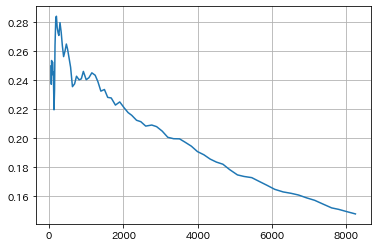

In [27]:
(g['n_hits'] / g.index).plot()
plt.grid()

In [30]:
g_tansho = gain(me.tansho_return, X_test)

100%|██████████| 100/100 [04:02<00:00,  2.42s/it]


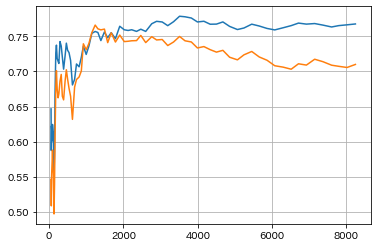

In [31]:
plt.plot(g.index, g['return_rate'])
plt.plot(g_tansho.index, g_tansho['return_rate'])
plt.grid()

In [32]:
g_tansho.max()

return_rate       0.766048
n_hits         1219.000000
dtype: float64

### 8．回収率の標準偏差

In [68]:
me = ModelEvaluator(lgb_clf, 'return_tables.pickle')

In [51]:
g = gain(me.tansho_return, X_test)

100%|██████████| 100/100 [03:52<00:00,  2.32s/it]


In [52]:
g

,return_rate,n_hits,std
8244,0.709959,1219.0,0.022119
8019,0.705624,1198.0,0.022115
7795,0.707300,1177.0,0.022511
7604,0.708877,1156.0,0.022937
7370,0.713881,1140.0,0.023300
...,...,...,...
10,0.350000,1.0,0.350000
7,0.500000,1.0,0.500000
6,0.000000,0.0,0.000000
4,0.000000,0.0,0.000000


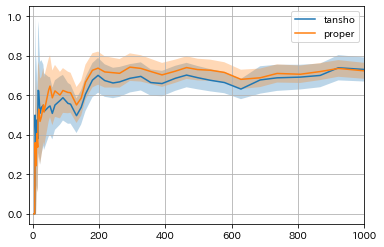

In [72]:
plt.fill_between(g.index, y1=g['return_rate']-g['std'], y2=g['return_rate']+g['std'], alpha=0.3)
plt.plot(g.index, g['return_rate'], label='tansho')
plt.fill_between(g_proper.index, y1=g_proper['return_rate']-g_proper['std'], y2=g_proper['return_rate']+g_proper['std'], alpha=0.3)
plt.plot(g_proper.index, g_proper['return_rate'], label='proper')
plt.xlim(-10, 1000)
plt.legend()
plt.grid()

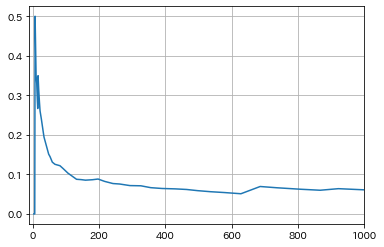

In [62]:
plt.plot(g.index, g['std'])
plt.xlim(-10, 1000)
plt.grid()

In [69]:
g_proper = gain(me.tansho_return_proper, X_test)

100%|██████████| 100/100 [03:41<00:00,  2.21s/it]


In [70]:
g_proper

,return_rate,n_hits,std
8244,0.767636,1219.0,0.013972
8019,0.766408,1198.0,0.014249
7795,0.765270,1177.0,0.014531
7604,0.763340,1156.0,0.014802
7370,0.765999,1140.0,0.015091
...,...,...,...
10,0.243525,1.0,0.243525
7,0.359878,1.0,0.359878
6,0.000000,0.0,0.000000
4,0.000000,0.0,0.000000


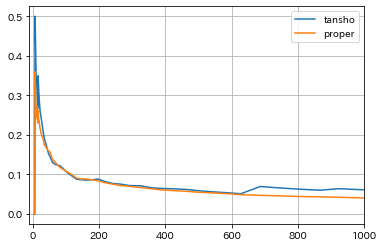

In [71]:
plt.plot(g.index, g['std'], label='tansho')
plt.plot(g_proper.index, g_proper['std'], label='proper')
plt.xlim(-10, 1000)
plt.legend()
plt.grid()

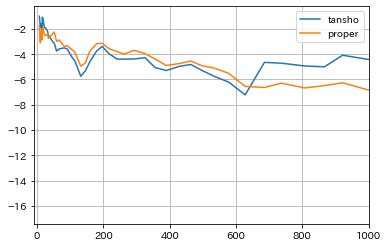

In [73]:
plt.plot(g.index, (g['return_rate'] - 1) / g['std'], label='tansho')
plt.plot(g_proper.index, (g_proper['return_rate'] - 1) / g_proper['std'], label='proper')
plt.xlim(-10, 1000)
plt.legend()
plt.grid()